In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#importing packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [ ]:
#setting figure size
rcParams['figure.figsize'] = 20,10

#for normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/My Drive/Covid 19 part(2)/LSTM/TESLA_JULY15_JULY20.csv')
df['Date'] = df[['Date', 'Time']].apply(lambda x: '-'.join(x), axis=1)
#print the head
df

,Date,Time,Open,High,Low,Close,Up,Down
0,7/1/2020-09:35,09:35,1083.00,1105.00,1080.50,1096.96,266085,171277
1,7/1/2020-09:40,09:40,1097.16,1100.84,1090.59,1100.33,144351,146374
2,7/1/2020-09:45,09:45,1100.72,1117.28,1100.27,1110.44,199714,187722
3,7/1/2020-09:50,09:50,1110.12,1118.00,1106.00,1115.84,144147,146348
4,7/1/2020-09:55,09:55,1115.74,1116.19,1105.00,1108.02,96027,117973
...,...,...,...,...,...,...,...,...
1087,7/21/2020-15:40,15:40,1572.86,1573.93,1558.58,1564.33,60201,65424
1088,7/21/2020-15:45,15:45,1564.45,1570.86,1562.05,1570.59,37591,35607
1089,7/21/2020-15:50,15:50,1570.59,1582.42,1568.79,1580.54,53218,45424
1090,7/21/2020-15:55,15:55,1579.43,1579.43,1564.00,1571.44,52035,60239


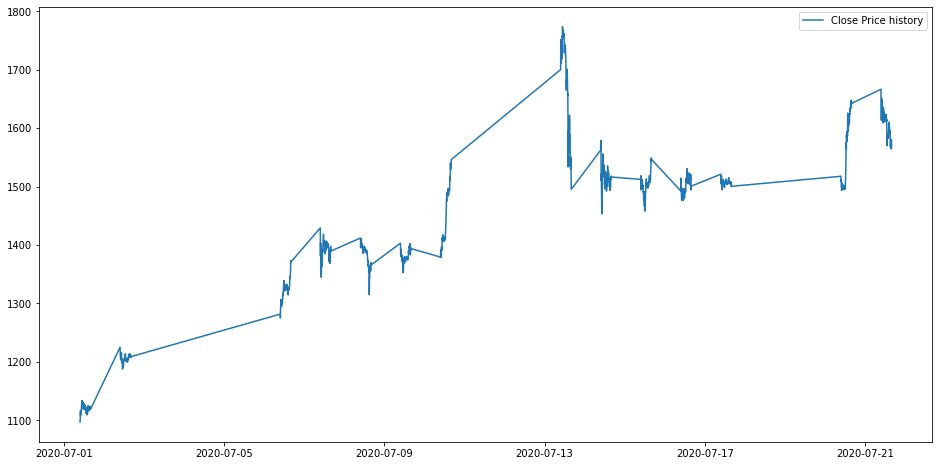

In [ ]:
#setting index as date
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d-%H:%M')
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.legend()

In [ ]:
df

,Date,Time,Open,High,Low,Close,Up,Down
Date,,,,,,,,
2020-07-01 09:35:00,2020-07-01 09:35:00,09:35,1083.00,1105.00,1080.50,1096.96,266085,171277
2020-07-01 09:40:00,2020-07-01 09:40:00,09:40,1097.16,1100.84,1090.59,1100.33,144351,146374
2020-07-01 09:45:00,2020-07-01 09:45:00,09:45,1100.72,1117.28,1100.27,1110.44,199714,187722
2020-07-01 09:50:00,2020-07-01 09:50:00,09:50,1110.12,1118.00,1106.00,1115.84,144147,146348
2020-07-01 09:55:00,2020-07-01 09:55:00,09:55,1115.74,1116.19,1105.00,1108.02,96027,117973
...,...,...,...,...,...,...,...,...
2020-07-21 15:40:00,2020-07-21 15:40:00,15:40,1572.86,1573.93,1558.58,1564.33,60201,65424
2020-07-21 15:45:00,2020-07-21 15:45:00,15:45,1564.45,1570.86,1562.05,1570.59,37591,35607
2020-07-21 15:50:00,2020-07-21 15:50:00,15:50,1570.59,1582.42,1568.79,1580.54,53218,45424


In [ ]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[:800,:]
valid = dataset[800:,:]



In [ ]:
#converting dataset into x_train and y_train
T = 30 #training period
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(T,len(train)):
    x_train.append(scaled_data[i-T:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape, y_train.shape)

(770, 30, 1) (770,)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.summary()

In [ ]:
import time
start = time.time()
model.fit(x_train, y_train, epochs=50, batch_size=8)
end = time.time()
print('Run time: {}'.format((end-start)/60))

In [ ]:
#predicting test values from past T days
inputs = new_data[len(new_data) - len(valid) - T:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(T,inputs.shape[0]):
    X_test.append(inputs[i-T:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
#rms error
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
np.mean(np.abs(valid - closing_price))

15.249230689479877

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


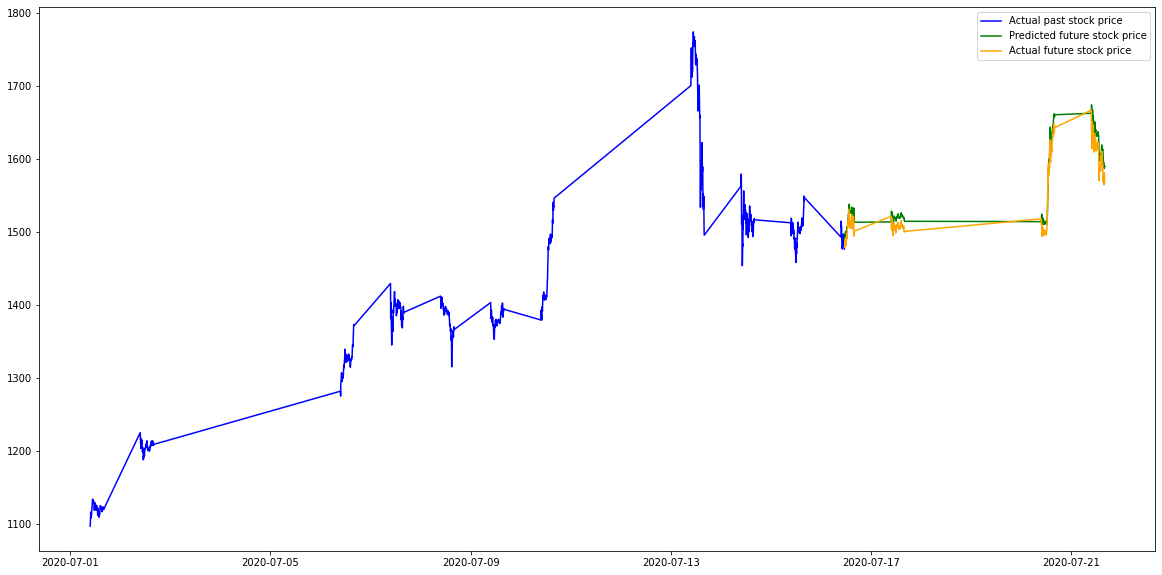

In [ ]:
#for plotting
train = new_data[:800]
valid = new_data[800:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')

#train['Close'].plot(color='blue', label='Actual past stock price')
plt.legend()



In [ ]:

valid

,Close,Predictions
Date,,
2020-07-16 11:15:00,1478.92,1489.131958
2020-07-16 11:20:00,1481.47,1488.369019
2020-07-16 11:25:00,1483.42,1490.291016
2020-07-16 11:30:00,1486.56,1493.271118
2020-07-16 11:35:00,1485.29,1496.608276
...,...,...
2020-07-21 15:40:00,1564.33,1593.002197
2020-07-21 15:45:00,1570.59,1588.310059
2020-07-21 15:50:00,1580.54,1586.723633


In [ ]:
valid.to_csv('/content/drive/My Drive/Covid 19 part(2)/Results_1/TESLA_Predicted_vs_Actual_Stock_Prices_JULY.csv')

In [ ]:
#Prediction for 22nd July, 2017
inputs = new_data[len(new_data) - T:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = inputs
X_test = X_test.reshape(1,T,1)

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
print('Price on 22nd July : {}'.format(closing_price[0][0]))

Price on 22nd July : 1586.398193359375


In [ ]:
inputs = new_data[len(new_data) - T:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(T,inputs.shape[0]):
    X_test.append(inputs[i-T:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price) 
closing_price #single valued output prediction

In [ ]:
inputs.shape
X_test = inputs

In [ ]:
X_test = X_test.reshape(1,T,1)
X_test.shape

(1, 30, 1)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
closing_price

array([[1586.3982]], dtype=float32)

In [ ]:
valid
valid.to_csv('/content/drive/My Drive/Covid 19 part(2)/LSTM/GOOGLE_Predicted_vs_Actual_Stock_Prices.csv')


In [ ]:
valid

,Close,Predictions
Date,,
2019-11-01,255.82,247.457855
2019-11-04,257.5,251.348511
2019-11-05,257.13,255.735565
2019-11-06,257.24,258.554657
2019-11-07,259.43,259.795258
...,...,...
2020-07-10,383.68,359.735291
2020-07-13,381.91,362.386932
2020-07-14,388.23,362.968323


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Covid 19 part(2)/LSTM/AAPL_JAN18_JULY20.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
data_training = data[data['Date'] < '2019-12-31'].copy()
data_training

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
485,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.562683,24643000
486,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.831299,12119700
487,2019-12-26,284.820007,289.980011,284.700012,289.910004,288.442780,23280300
488,2019-12-27,291.119995,293.970001,288.119995,289.799988,288.333313,36566500


In [ ]:
data_testing = data[data['Date'] >= '2019-12-31'].copy()
data_testing

,Date,Open,High,Low,Close,Adj Close,Volume
490,2019-12-31,289.929993,293.679993,289.519989,293.649994,292.163818,25201400
491,2020-01-02,296.239990,300.600006,295.190002,300.350006,298.829956,33870100
492,2020-01-03,297.149994,300.579987,296.500000,297.429993,295.924713,36580700
493,2020-01-06,293.790009,299.959991,292.750000,299.799988,298.282715,29596800
494,2020-01-07,299.839996,300.899994,297.480011,298.390015,296.879883,27218000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
training_data = data_training.drop(['Date', 'Adj Close'], axis=1)
training_data

,Open,High,Low,Close,Volume
0,178.610001,179.580002,177.410004,178.460007,32425100
1,177.300003,177.779999,176.600006,177.000000,27108600
2,177.300003,179.440002,176.820007,177.039993,32689100
3,177.250000,177.300003,173.199997,174.220001,51105100
4,174.509995,174.949997,170.529999,171.110001,41529000
...,...,...,...,...,...
485,280.529999,284.250000,280.369995,284.000000,24643000
486,284.690002,284.890015,282.920013,284.269989,12119700
487,284.820007,289.980011,284.700012,289.910004,23280300
488,291.119995,293.970001,288.119995,289.799988,36566500


In [ ]:
scalar = MinMaxScaler()
training_data = scalar.fit_transform(training_data)
training_data.shape

(490, 5)

In [ ]:
x_train = []
y_train = []

T = 60
for i in range(T, training_data.shape[0]):
  x_train.append(training_data[i-T:i])
  y_train.append(training_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(430, 60, 5)
(430,)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,901
Trainable params: 91,901
Non-trainable params: 0
__________________________________________________

In [ ]:
import time
start = time.time()
model.fit(x_train, y_train, epochs=50, batch_size=8)
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0159
Epoch 2/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0041
Epoch 3/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0029
Epoch 4/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0030
Epoch 5/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 6/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0024
Epoch 8/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0024
Epoch 9/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0038
Epoch 10/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0022
Epoch 11/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0019
Epoch 12/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0020
Epoch 13/50
54/54 [==================

In [ ]:
past_T_days = data_training.tail(T)

df = past_T_days.append(data_testing, ignore_index = True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-04,225.639999,227.490005,223.889999,227.009995,225.185043,34619700
1,2019-10-07,226.270004,229.929993,225.839996,227.059998,225.234634,30576500
2,2019-10-08,225.820007,228.059998,224.330002,224.399994,222.596024,27955000
3,2019-10-09,227.029999,227.789993,225.639999,227.029999,225.204895,18692600
4,2019-10-10,227.929993,230.440002,227.300003,230.089996,228.240280,28253400
...,...,...,...,...,...,...,...
192,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
193,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
194,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
195,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
df = df.drop(['Date', 'Adj Close'], axis=1)
df

,Open,High,Low,Close,Volume
0,225.639999,227.490005,223.889999,227.009995,34619700
1,226.270004,229.929993,225.839996,227.059998,30576500
2,225.820007,228.059998,224.330002,224.399994,27955000
3,227.029999,227.789993,225.639999,227.029999,18692600
4,227.929993,230.440002,227.300003,230.089996,28253400
...,...,...,...,...,...
192,381.339996,383.920013,378.820007,383.679993,22564300
193,389.059998,399.820007,381.029999,381.910004,47912300
194,379.359985,389.019989,375.510010,388.230011,42747300
195,395.959991,396.989990,385.959991,390.899994,38299500


In [ ]:
inputs = scalar.transform(df)
inputs.shape

(197, 5)